# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [131]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading and preparing data

We have chosen two datasets. The first one is a dataset that shows the return to schooling for 150 countries. We limit the analysis to all EU countries as they all have the return to schooling reported in the same year, 2019. The second dataset show government expenditures and GDP from 1980 to 2022. 

From the chosen data we aim to analyze the differences in return to schooling btw. the EU countries with a focus on Denmark. We do so by comparing the total return to schooling btw. all countries as well gender specific return to schooling. On top of this we also aim to analyze the covariation between return to schooling and average government expenditures in education per capita from 1980-2019 as well as GDP per capita in 2019.

In [132]:
# The two datasets are loaded
return_to_schooling = 'Data_Return_To_Schooling.dta' ; rts = pd.read_stata(return_to_schooling)
government_expenditure = 'Data_Government_Expenditures.dta' ; gexp = pd.read_stata(government_expenditure)

# List of all 27 EU countries
eu_countries = [
    "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", 
    "Czechia", "Denmark", "Estonia", "Finland", "France", 
    "Germany", "Greece", "Hungary", "Ireland", "Italy", 
    "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands", 
    "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", 
    "Spain", "Sweden"]


In the following the data set containing data on return to schooling is prepped and made ready for analysis.

In [133]:
# Step a: Remove all non-european-union countries
I = False
for i in eu_countries :
    I |= rts.isoname.str.contains(i)

rts_eu = rts.loc[I].reset_index()

# Step b: Remove returns to schooling for primary, secondary and tertiary education as well the extra index as these are not of interest to us.
for j in ['coef_','lb_','ub_'] :
    drop_these = [j + x for x in ['yrl_pri','yrl_sec','yrl_ter']]
    rts_eu.drop(drop_these, axis = 1, inplace = True)

del rts_eu['index']

# Step c: Rename variables such that they are easy to understand
rename_dict = {}
rename_dict['isoname'] = 'country'
rename_dict['coef_yrs'] = 'return_to_schooling'
rename_dict['lb_yrs'] = 'lower_rts'
rename_dict['ub_yrs'] = 'upper_rts'
rename_dict['coef_yrs_sex_0'] = 'rts_women'
rename_dict['lb_yrs_sex_0'] = 'lower_rts_women'
rename_dict['ub_yrs_sex_0'] = 'upper_rts_women'
rename_dict['coef_yrs_sex_1'] = 'rts_men'		
rename_dict['lb_yrs_sex_1'] = 'lower_rts_men'
rename_dict['ub_yrs_sex_1'] = 'upper_rts_men'
rts_eu.rename(columns = rename_dict, inplace = True)

# Step d: The units are in decimals, we choose to change units into percentages
for key,value in rename_dict.items() :
    if value != 'country' :
        rts_eu[value] = rts_eu[value] * 100
    else :
        continue

# Step e: The dataset is sorted from smallets return to schooling to largest
rts_eu_sorted = rts_eu.sort_values('return_to_schooling').reset_index()

In the following the data set containing data on government expenditures and GDP is prepped and made ready for analysis.

In [134]:
# Step a: Remove all non-european-union countries 
I = False
for i in eu_countries :
    I |= gexp.isoname.str.contains(i)

gexp_eu = gexp.loc[I].reset_index()

# Step b: Keep variables of interest
keep_these = ['isoname','iso','year','gdp','gova_educ','npop']
gexp_eu = gexp_eu.loc[:,keep_these]

# Step c: Create per capita variables (in 1000 dollars)
for i in ['gdp','gova_educ'] :
    gexp_eu[i + '_cap_t'] = gexp_eu[i] / (gexp_eu['npop'] * 1000)
    del gexp_eu[i]

# Step d: Rename isoname to country such that it matches the dataset rts_eu_sorted
gexp_eu.rename(columns = {'isoname':'country'}, inplace = True)

# Step e: We remove all years 2020-2022 as they are after the record of return to schooling in 2019
J = False
for j in [2020,2021,2022] :
    J |= gexp.year == j

gexp_eu = gexp_eu.loc[J == False].reset_index()

# Step f: Calculate the average government expenditures into schooling per capita from 1980-2019
gexp_eu['avg_gov_educ_exp'] = gexp_eu.groupby('country')['gova_educ_cap_t'].transform('mean')

# Step g: As the return to schooling is noted in 2019 we only keep the relevant year (i.e. gdp per capita for 2019 and average government spending from 1980 to 2019)
gexp_eu_2019 = gexp_eu.groupby('country').last().reset_index()

# Step h: Create the logarithims of the variables for plotting
gexp_eu_2019['avg_gov_educ_exp_log'] = np.log(gexp_eu_2019['avg_gov_educ_exp'])
gexp_eu_2019['gdp_cap_t_log'] = np.log(gexp_eu_2019['gdp_cap_t'])

# Step i: Remove index before merging
del gexp_eu_2019['index']


# Merging datasets

In this section we merge the prepped return to schooling and government expenditures datasets.

In [135]:
# Doing a left merge on country and iso (We do it on iso as it is in both datasets)
gexp_rts_eu = pd.merge(rts_eu_sorted, gexp_eu_2019, on = ['country','iso'], how = 'left')
del gexp_rts_eu['index']

# The full datasets can be shown
gexp_rts_eu.head(27)

,country,iso,return_to_schooling,lower_rts,upper_rts,rts_women,lower_rts_women,upper_rts_women,rts_men,lower_rts_men,upper_rts_men,year,npop,gdp_cap_t,gova_educ_cap_t,avg_gov_educ_exp,avg_gov_educ_exp_log,gdp_cap_t_log
0,Portugal,PT,8.537110,8.424878,8.649342,9.306932,9.146111,9.467753,7.739199,7.585140,7.893258,2019.0,10289923.0,20.833436,0.931008,0.614089,-0.487615,3.036559
1,Italy,IT,8.810863,8.368219,9.253508,9.725856,9.056469,10.395243,8.054729,7.464427,8.645030,2019.0,60195780.0,28.606045,1.164085,0.833057,-0.182653,3.353618
2,Greece,GR,8.811475,8.154680,9.468268,10.907956,9.625652,12.190261,7.616029,6.913229,8.318830,2019.0,10623177.0,17.259550,0.688495,0.445593,-0.808349,2.848366
3,France,FR,9.763430,9.557838,9.969022,10.602239,10.256433,10.948046,9.058083,8.810096,9.306069,2019.0,66442484.0,35.538907,1.925365,1.266684,0.236403,3.570628
4,Luxembourg,LU,10.301188,9.501303,11.101073,11.779902,10.331982,13.227822,9.256530,8.374347,10.138714,2019.0,619973.0,100.606885,4.840533,2.438110,0.891223,4.611221
5,Spain,ES,10.857859,10.303720,11.411999,12.712818,11.850718,13.574919,9.586326,8.868175,10.304476,2019.0,47039080.0,26.228499,1.064094,0.604815,-0.502832,3.266847
6,Poland,PL,11.047719,10.364385,11.731054,12.829378,11.711324,13.947433,9.657219,8.836878,10.477562,2019.0,38493600.0,59.451212,2.984444,1.108242,0.102775,4.085156
7,Slovakia,SK,11.494584,10.150826,12.838343,11.778298,10.000385,13.556212,11.245753,9.259441,13.232066,2019.0,5453924.0,17.315480,0.734700,0.338875,-1.082125,2.851601
8,Czechia,CZ,11.759451,10.867955,12.650948,11.342204,10.016757,12.667651,12.134659,10.931787,13.337530,2019.0,10544486.0,549.244720,26.671854,14.369039,2.665076,6.308544
9,Malta,MT,11.868278,10.896626,12.839927,12.874414,11.335876,14.412950,11.256679,10.000181,12.513176,2019.0,503635.0,27.892995,1.413722,0.582433,-0.540542,3.328376


# Analyzing data: Summary statistics

To begin the data analisys we provide an overview of summary statistics for all variables excluding confidence bounds.

In [136]:
gexp_rts_eu.loc[:,['return_to_schooling','rts_women','rts_men','gdp_cap_t','gdp_cap_t_log','avg_gov_educ_exp','avg_gov_educ_exp_log']].describe()

,return_to_schooling,rts_women,rts_men,gdp_cap_t,gdp_cap_t_log,avg_gov_educ_exp,avg_gov_educ_exp_log
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,13.536271,14.733476,12.595617,262.359612,3.983917,5.696519,0.284197
std,3.141095,3.406411,3.213032,906.022912,1.341111,16.280856,1.398334
min,8.537110,9.306932,7.616029,16.007195,2.773038,0.182783,-1.699455
25%,11.271152,12.246360,10.228130,21.946101,3.087500,0.578706,-0.546981
50%,13.874195,14.201361,12.675545,39.791003,3.683641,1.050736,0.049491
75%,15.366138,16.665274,14.681035,66.153635,4.186821,1.520662,0.418810
max,20.104675,22.646791,21.189346,4737.364077,8.463236,83.462583,4.424398


From the summary statistics we see that the mean return to schooling is 13.53 pct. in 2019 with values that vary between 8.54 and 20.1 pct. In general the average return to schooling is higher for women at 14.73 pct. than for men at 12.59 pct. Return to schooling is also seen to be close to symmetric as median and average values are close.

The GDP per capita average is 262.35 thousand dollars with a very large standard deviation of 906.02 thousand dollars. It is seen that the variable is largely right skewed we therefore make the log transformation to get a more symmetrically distributed variable.

The average government expenditures in education per capita is 5.69 thousand dollars again with a large standard deviation and right skewness such that logs are taken.

# Analyzing data: Comparing return to schooling between countries

To compare return to schooling between the EU countries we plot a bar chart in ascending order. Denmark has been highlighted.

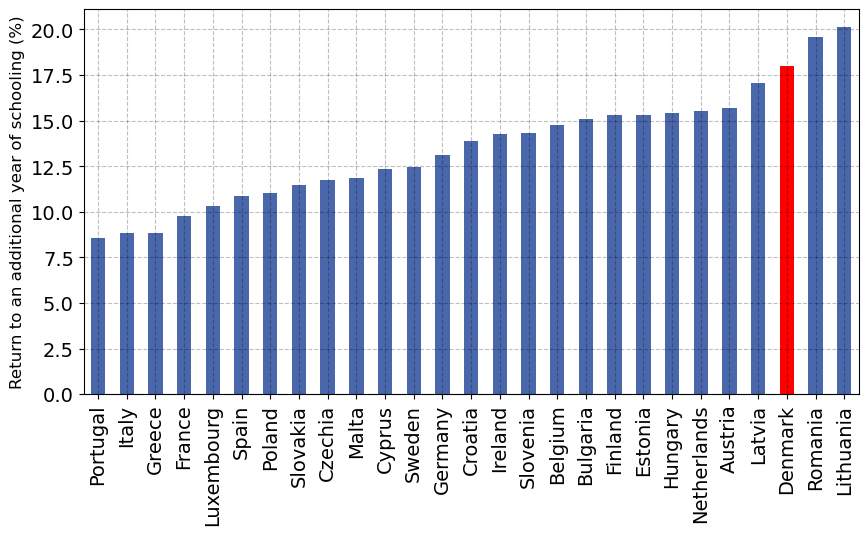

In [137]:
# We define our favorite colors
cbs_blue = (73/255, 103/255, 170/255) ; ku_red = (144/255, 26/255, 30/255)

# We use pandas built in plot function to make a bar chart of our favorite pies
ax = gexp_rts_eu.plot(x = 'country', y = 'return_to_schooling', kind = 'bar', 
                        figsize=(10, 5), color = cbs_blue, legend = False) ; 

# We higlight the bar for Denmark
bars = ax.patches
DK = gexp_rts_eu.index[rts_eu_sorted['country'] == 'Denmark'].tolist()[0]
bars[DK].set_facecolor('red')

# We add labels to the chart
ax.set_xlabel('') 
ax.set_ylabel('Return to an additional year of schooling (%)', fontsize = 12) ;

From the chart we see that the country with the smallest return to schooling is Portugal while the one with the largest return is Lithuania. From the chart it is evident that Denmark is the country with the third largest return to schooling.

# Analyzing data: Return schooling differences for men and women

To compare return to schooling btw. men and women we make a scatterplot with a 45 degree line, such that any country above the 45 degree line has a larger return to schooling for women than men.

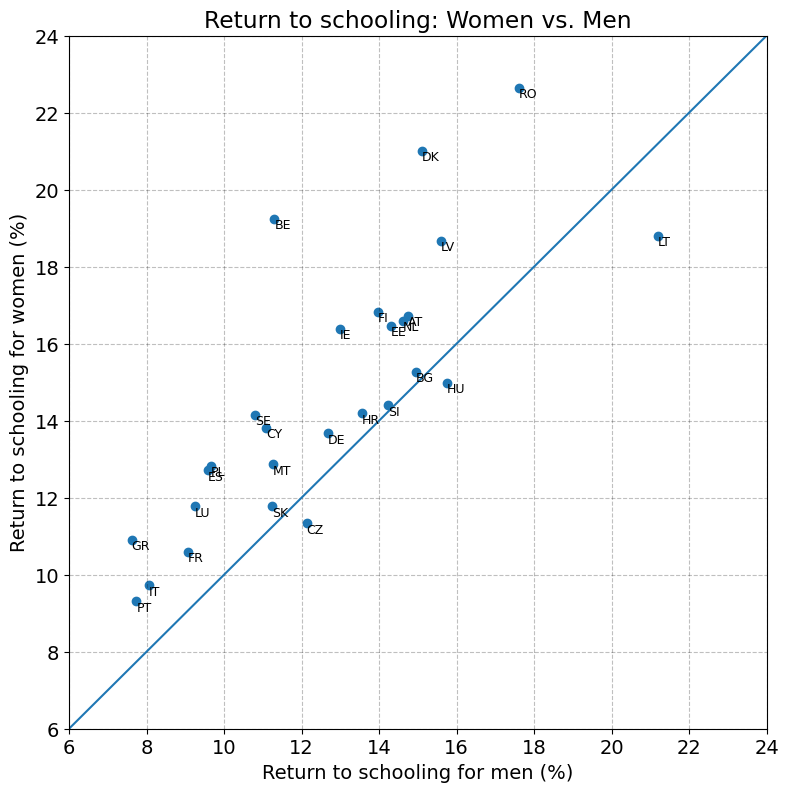

In [138]:
# Make the axes for the 45 degree line
deg_45_line = np.linspace(6,24,19)

# Define a figure
fig = plt.figure(figsize = (9,9))
ax1 = fig.add_subplot(1,1,1)

# Plot the return to schooling for women against the one for men as well as the 45 degree line
ax1.plot(deg_45_line,deg_45_line)
ax1.scatter(gexp_rts_eu['rts_men'],gexp_rts_eu['rts_women'])

# Give each point a name corresponding to their isocode
for i, label in enumerate(gexp_rts_eu['iso']) :
    ax1.text(gexp_rts_eu['rts_men'][i],gexp_rts_eu['rts_women'][i],label,fontsize = 9, ha = 'left', va = 'top')

# Set limits and labels
ax1.set_ylim(6,24) ; ax1.set_xlim(6,24)
ax1.set_ylabel('Return to schooling for women (%)')
ax1.set_xlabel('Return to schooling for men (%)') 
ax1.set_title('Return to schooling: Women vs. Men') ;

From the plot we see that only Hungary, Lithunia and Czechia has a larger return to schooling for men than women while every other country has the opposite. We also see that Denmark places quite high up the table such that the return to schooling for women is quite large compared for men.

# Analyzing data: Covariation btw. return to schooling and expenditures / GDP

To analyze the covariation between government expenditures in education per capita and return to schooling we make a scatter plot with a linear fit. In this way we may see if the covariation is positive or negative. The same is done for GDP per capita.

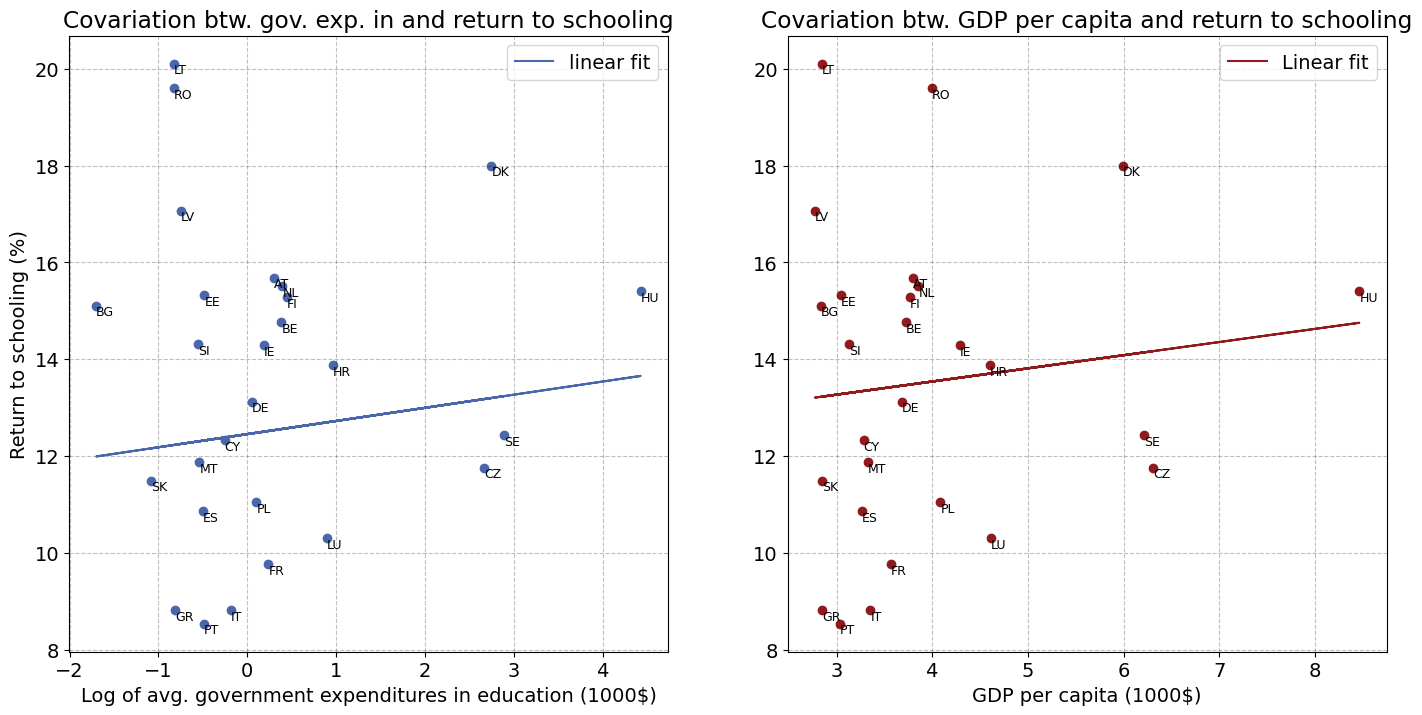

In [139]:
# We define our favorite colors
cbs_blue = (73/255, 103/255, 170/255) ; ku_red = (144/255, 26/255, 30/255)

# We define a figure
fig = plt.figure(figsize = (17,8))

# We want two subplots
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Figure 1: Gov exp and return to schooling
ax1.scatter(gexp_rts_eu['avg_gov_educ_exp_log'],gexp_rts_eu['return_to_schooling'], color = cbs_blue)

ax1.set_ylabel('Return to schooling (%)')
ax1.set_xlabel('Log of avg. government expenditures in education (1000$)', fontsize = 14) 
ax1.set_title('Covariation btw. gov. exp. in and return to schooling')

# Make a linear fit and plot it
slope1, intercept1 = np.polyfit(gexp_rts_eu['avg_gov_educ_exp_log'],gexp_rts_eu['return_to_schooling'],1)
yfit1 = slope * gexp_rts_eu['avg_gov_educ_exp_log'] + intercept
ax1.plot(gexp_rts_eu['avg_gov_educ_exp_log'],yfit1, color = cbs_blue, label = 'linear fit')

ax1.legend()

# Figure 2: GDP and return to schooling
ax2.scatter(gexp_rts_eu['gdp_cap_t_log'], gexp_rts_eu['return_to_schooling'], color = ku_red)
# ax2.set_ylabel('Return to schooling (%)',fontsize = 11)
ax2.set_xlabel('GDP per capita (1000$)',fontsize = 14) 
ax2.set_title('Covariation btw. GDP per capita and return to schooling')

# Make a linear fit and plot it
slope2, intercept2 = np.polyfit(gexp_rts_eu['gdp_cap_t_log'],gexp_rts_eu['return_to_schooling'],1)
yfit2 = slope * gexp_rts_eu['gdp_cap_t_log'] + intercept
ax2.plot(gexp_rts_eu['gdp_cap_t_log'],yfit2, color = ku_red, label = 'Linear fit')

ax2.legend()

# Add text labels to all points
for i, label in enumerate(gexp_rts_eu['iso']) :
    ax1.text(gexp_rts_eu['avg_gov_educ_exp_log'][i],gexp_rts_eu['return_to_schooling'][i],label,fontsize = 9, ha = 'left', va = 'top')
    ax2.text(gexp_rts_eu['gdp_cap_t_log'][i],gexp_rts_eu['return_to_schooling'][i],label,fontsize = 9, ha = 'left', va = 'top') ;


From the two figures we notice that countries with larger GDP per capita usually spends more on education, and that there is a positive covariation between wealth and expenditures in education to the return to schooling. The covariation however isn't very large as seen from the linear fit. In both figures wee that Denmark places in the top left right corner with high return to schooling and large government expenditures in schooling per capita as well as GDP per capita. 

One thing to notice is that the countries with the highest return to schooling, namely Lithuania and Romania are placed amon the poorer countries with smaller expenditures in education.

# Conclusion

Too conclude we have shown that Denmark is among the countries in the EU with highest return to schooling. We have also shown that in general womens return to schooling is larger than that of the men. Lastly we have shown that there is an overall positive correlation between government expenditures in education per capita as well as GDP per capita and return to schooling. However this correlation is a bit muddy as some of the countries with highest return to schooling are among the poorest.